In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    accuracy_score, precision_score, 
    recall_score, roc_auc_score, 
    silhouette_score, make_scorer
)
from scipy.cluster.hierarchy import dendrogram, linkage

from lightgbm import LGBMClassifier

In [2]:
sns.set(font_scale=1.2, palette='Set2')

# Прогнозирование вероятности оттока клиентов сети фитнес-центров

* [Описание проекта](#project_description)

* [Загрузка данных](#data_loading)

* [EDA](#eda)

* [Модели прогнозирования оттока клиентов](#models)

    * [Логистическая регрессия](#lr)
    
    * [Решающее дерево](#dtc)
    
    * [Случайный лес](#rf)
    
    * [Градиентный бустинг](#lgb)
    
    * [Вывод](#models_conclusion)
    
* [Кластеризация клиентов](#clustering)

* [Общий вывод и рекомендации](#genral_conclusion_and_recommendations)

## Описание проекта <a name='project_description'></a>

На основе данных клиентов сети фитнес-центров нужно:

* научиться прогнозировать вероятность оттока для каждого клиента на уровне следующего месяца

* сформировать портреты клиентов

* проанализировать признаки, которые сильнее всего влияют на отток

* сделать рекомендации по повышению качества работы с клиентами

## Загрузка данных <a name='data_loading'></a>

In [3]:
df = pd.read_csv('../datasets/gym_churn.csv')
df.columns = list(map(lambda col: col.lower(), df))
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## EDA <a name='eda'></a>

Посмотрим на общую информацию по датафрейму.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Есть сведения о 4000 клиентах. В данных нет пропусков. С типами признаков все хорошо, можно только привести признак `month_to_end_contract` к типу `int`.

In [5]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

Посмотрим на главные статистики по признакам.

In [6]:
df.describe().drop('count').T

,mean,std,min,25%,50%,75%,max
gender,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


* Распределение по полу примерно одинаковое (51% и 49%)

* В основном клиенты живут или работают рядом с фитнес-центром – 85% клиентов

* Чуть меньше половины клиентов (48%) – это сотрудники компаний-партнеров

* 30% клиентов пришло через рекомендации друзей

* Свой контактный телефон дали 90% клиентов

* В сеть фитнес-центров ходят люди молодого и среднего возраста

* Типичный клиент уже занимается в сети фитнес-центров около 4 месяцев

* В последнем месяце

    * По карйней мере у половины клиентов заканчивался абонемент

    * Около 40% клиентов ходило на занятия в группах 

    * Обычно клиенты занимались 2 раза в неделю

В итоге каждый 3 клиент попал в отток.

Посмотрим на средние значения бинарных признаков по факту оттока.

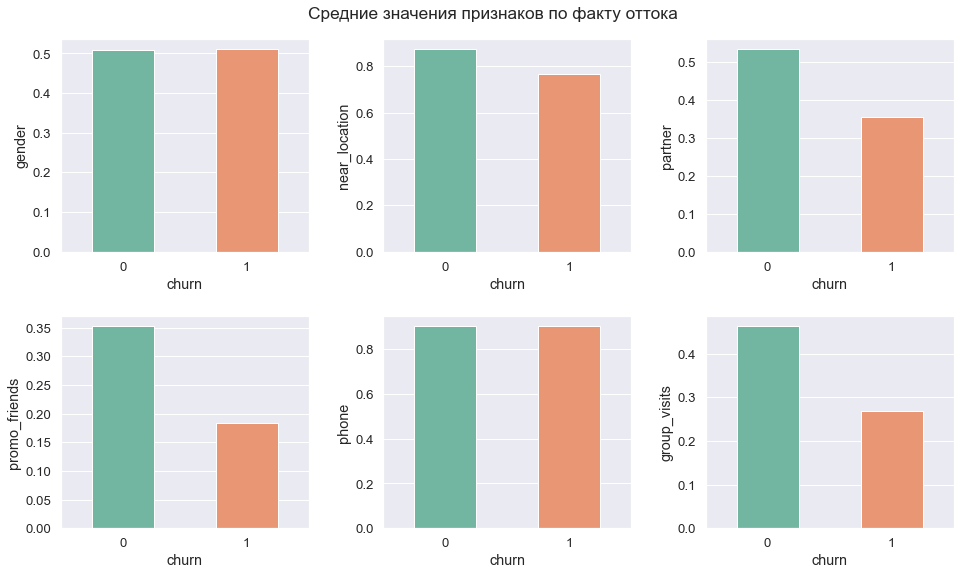

In [7]:
binary_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))
for i, col in enumerate(binary_features):
    sns.barplot(data=df, y=col, x='churn', width=0.5, errorbar=None, ax=axes[i // 3, i % 3])
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Средние значения признаков по факту оттока', y=0.93);

In [8]:
pd.pivot_table(data=df, columns='churn', values=binary_features)

churn,0,1
gender,0.510037,0.510839
group_visits,0.464103,0.268615
near_location,0.873086,0.768143
partner,0.534195,0.355325
phone,0.903709,0.902922
promo_friends,0.353522,0.183789


* Доля посещавших групповые занятия в последнем месяце почти в 2 раза больше среди оставшихся клиентов

* Доля тех, у кого дом или работа рядом с фитнес-центром, немного меньше у решивших уйти клиентов

* Кажды второй оставшийся и третий ушедший является сотрудником компании-партнера

* Ушедшие клиенты в 2 раза реже приходили по рекомендации друзей

Посмотрим на распределения отсальных признаков.

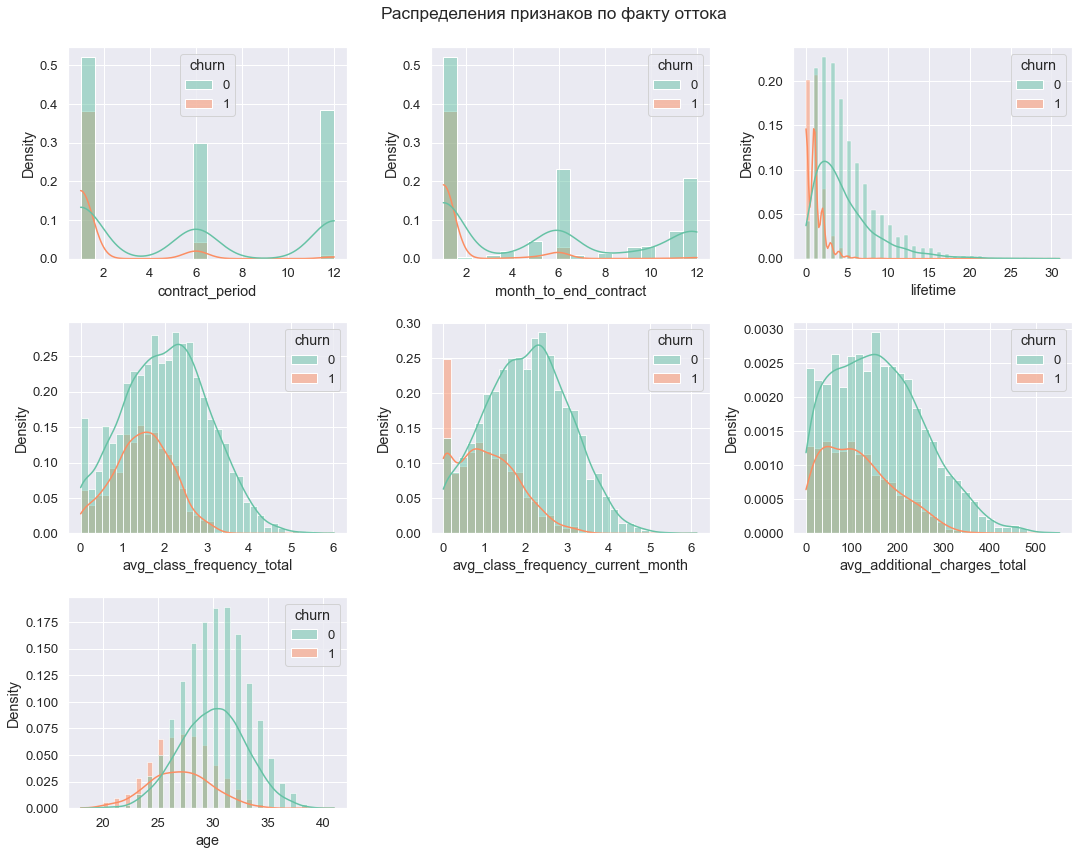

In [9]:
other_features = ['contract_period', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 
                 'avg_class_frequency_current_month', 'avg_additional_charges_total', 'age']

ncols, nrows = 3, 3
fig = plt.figure(figsize=(18, 14))
for i, col in enumerate(other_features):
    ax = fig.add_subplot(nrows, ncols, i + 1)
    sns.histplot(
        data=df, 
        x=col, 
        hue='churn',
        stat='density',
        kde=True,
        ax=ax
    )
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Распределения признаков по факту оттока', y=0.92);

In [10]:
pd.pivot_table(data=df, columns='churn', values=other_features)

churn,0,1
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
avg_class_frequency_current_month,2.027882,1.044546
avg_class_frequency_total,2.024876,1.474995
contract_period,5.747193,1.728558
lifetime,4.711807,0.990575
month_to_end_contract,5.283089,1.662582


In [11]:
df['contract_period'].value_counts(normalize=True)

1     0.55175
12    0.24000
6     0.20825
Name: contract_period, dtype: float64

In [12]:
pd.pivot_table(data=df, columns='contract_period', values='churn')

contract_period,1,6,12
churn,0.423199,0.12485,0.023958


* Больше чем у половины клиентов оставался 1 месяц абонемента. У таких клиентов самая высокая доля оттока

* Новые клиенты намного чаще уходили, чем оставались. По мере увеличения времени жизни доля оттока снижается. Клиенты, пользующиеся сервисом 6 месяцев и больше, почти не уходили

* Распределение средней частоты посещений в неделю в последнем месяце у ушедших клиентов смещено правее относительно распределения за все время. То есть в последний месяц ушедшие клиенты стали реже обычного посещать сеть фитнес-центров

* Средняя выручка от дополнительных услуг сети фитнес-центров больше у оставшихся клиентов

* В среднем ушедший клиент моложе оставшегося

Построим и отобразим матрицу корреляций.

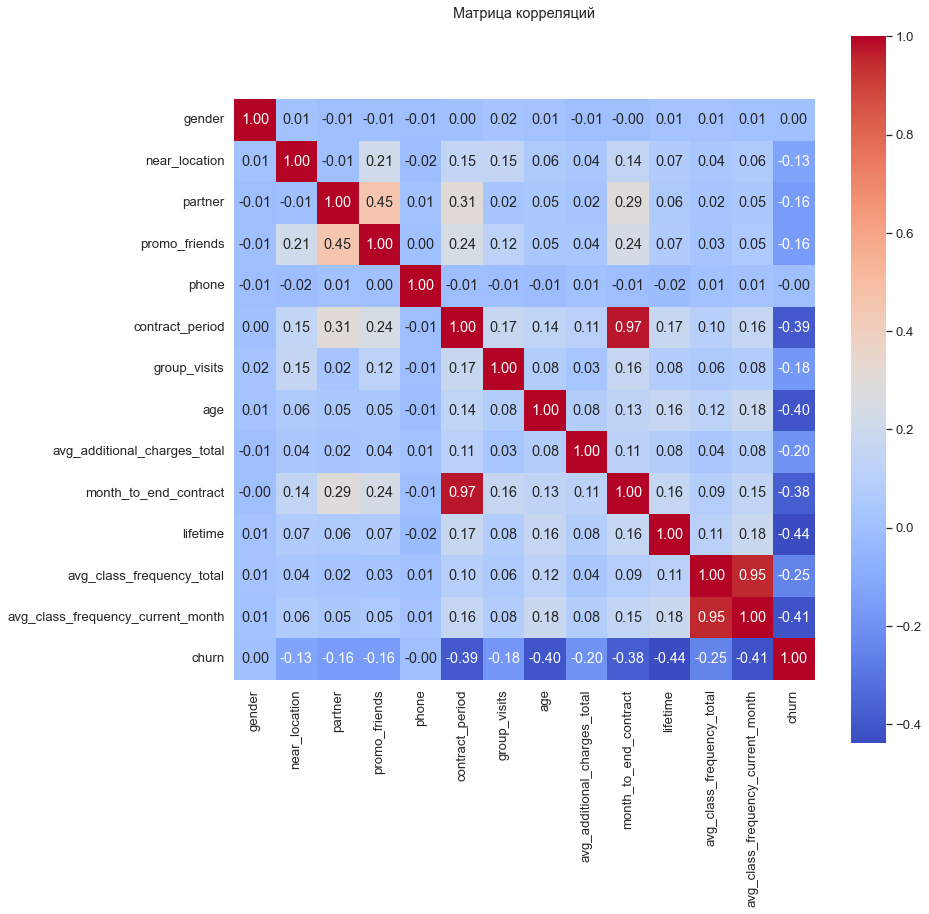

In [13]:
plt.figure(figsize=(13, 13))
sns.heatmap(data=df.corr(), annot=True, fmt='.2f', square=True, cmap=sns.color_palette('coolwarm', as_cmap=True))
plt.title('Матрица корреляций', y=1.13);

* Факт оттока имеет нулевую корреляцию с полом и наличием телефона. С оcтальными признаками у факта оттока слабая/умеренная, отрицательная корреляция (от -0,13 до -0,44)

* Сильная корреляция между признаками по абонементу (длительность и время до кончания) и посещению (средняя частота в неделю за последний месяц и все время)

## Модели прогнозирования оттока клиентов <a name='models'></a>

In [14]:
X = df.drop('churn', axis=1)
y = df['churn']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df['churn'], random_state=24
)

In [16]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': 'recall',  
    'ROC-AUC': 'roc_auc'
}

### Логистическая регрессия <a name='lr'></a>

In [17]:
pipeline = Pipeline([
    ('normalization', MinMaxScaler()), 
    ('logisticregression', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=24))
])

params = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

lr = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    scoring=scoring,
    refit='ROC-AUC',
    cv=5,
    return_train_score=True,
    n_jobs=-1
)

lr.fit(X_train, y_train);

In [18]:
def cross_validation_results(model):
    print('Лучшая модель')
    best_params = model.best_params_
    for param in best_params:
        param_value = best_params[param]
        print(f'{param}: {param_value}')
    i = model.cv_results_['params'].index(best_params)
    scores = {'train': {}, 'validation': {}}
    for metric in scoring:
        scores['train']['mean_' + metric] = model.cv_results_['mean_train_' + metric][i]
        scores['validation']['mean_' + metric] = model.cv_results_['mean_test_' + metric][i]
    display(pd.DataFrame(scores).round(3))

In [19]:
cross_validation_results(lr)

Лучшая модель
logisticregression__C: 100
logisticregression__penalty: l2


,train,validation
mean_accuracy,0.916,0.912
mean_precision,0.791,0.785
mean_recall,0.930,0.925
mean_ROC-AUC,0.977,0.976


In [20]:
def test_scores(model):
    print('Финальная проверка на тесте')
    y_pred_labels = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    print(f'Accuracy: {accuracy_score(y_test, y_pred_labels):.3f}')
    print(f'Precision: {precision_score(y_test, y_pred_labels):.3f}')
    print(f'Recall: {recall_score(y_test, y_pred_labels):.3f}')
    print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.3f}')

In [21]:
test_scores(lr)

Финальная проверка на тесте
Accuracy: 0.919
Precision: 0.805
Recall: 0.915
ROC-AUC: 0.977


На тесте результаты не ухудшились. Посмотрим на коэффициенты логистической регрессии.

In [22]:
features = X.columns
coefficients = lr.best_estimator_['logisticregression'].coef_[0]
feature_coefficients = pd.DataFrame({'feature': features, 'coefficient': coefficients})
feature_coefficients.sort_values(by='coefficient', ascending=False, key=lambda x: abs(x)).round(3)

,feature,coefficient
10,lifetime,-30.841
12,avg_class_frequency_current_month,-23.832
11,avg_class_frequency_total,18.531
7,age,-8.456
8,avg_additional_charges_total,-3.274
9,month_to_end_contract,-2.140
5,contract_period,-1.335
6,group_visits,-0.877
3,promo_friends,-0.469
2,partner,-0.237


* В нашей задаче полнота важнее точности. Как раз и получилось, что модель лучше находит ушедших клиентов, чем отличает ушедших от оставшихся

* Наибольшее влияние на предсказание модели оказывают время жизни клиента, его средняя частота посещений в неделю (за последний месяц и все время) и возраст. Интересно, что только у средней частоты посещения в неделю за все время коэффицент имеет положительный знак. Можно подумать, что чем чаще клиент посещает сеть фитнес-центров, тем с большей вероятностью он уйдет. Но тут важно учитывать еще посещение за последний месяц. Уверенность в том, что клиент скорее всего уйдет, повышается только тогда, когда клиент в последний месяц начинает заниматься в среднем в неделю в 1,3 раза реже или еще менее активно по сравнению со своей обычной активностью

### Решающее дерево <a name='dtc'></a>

In [23]:
estimator = DecisionTreeClassifier(class_weight='balanced', random_state=24)

params = {
    'criterion': ['entropy', 'gini'],
    'max_depth': np.arange(1, 11),
    'min_samples_leaf': [10, 20, 30, 40, 50]
}

dt= GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring=scoring,
    refit='ROC-AUC',
    cv=5,
    return_train_score=True,
    n_jobs=-1
)

dt.fit(X_train, y_train);

In [24]:
cross_validation_results(dt)

Лучшая модель
criterion: entropy
max_depth: 7
min_samples_leaf: 20


,train,validation
mean_accuracy,0.900,0.878
mean_precision,0.750,0.717
mean_recall,0.935,0.890
mean_ROC-AUC,0.973,0.944


In [25]:
test_scores(dt)

Финальная проверка на тесте
Accuracy: 0.880
Precision: 0.736
Recall: 0.854
ROC-AUC: 0.946


На тесте результаты не ухудшились. Посмотрим на оценку важности признаков.

In [26]:
importances = dt.best_estimator_.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances.sort_values(by='importance', ascending=False, key=lambda x: abs(x)).round(4)

,feature,importance
10,lifetime,0.4679
12,avg_class_frequency_current_month,0.1715
9,month_to_end_contract,0.1463
7,age,0.0931
11,avg_class_frequency_total,0.0818
8,avg_additional_charges_total,0.0210
5,contract_period,0.0149
6,group_visits,0.0035
0,gender,0.0000
1,near_location,0.0000


* У решающего дерева метрики хуже, чем у логистической регресии

* Среди важных признаков те же признаки, что и у логистической регресии, и количество месяцев до окончания абонемента

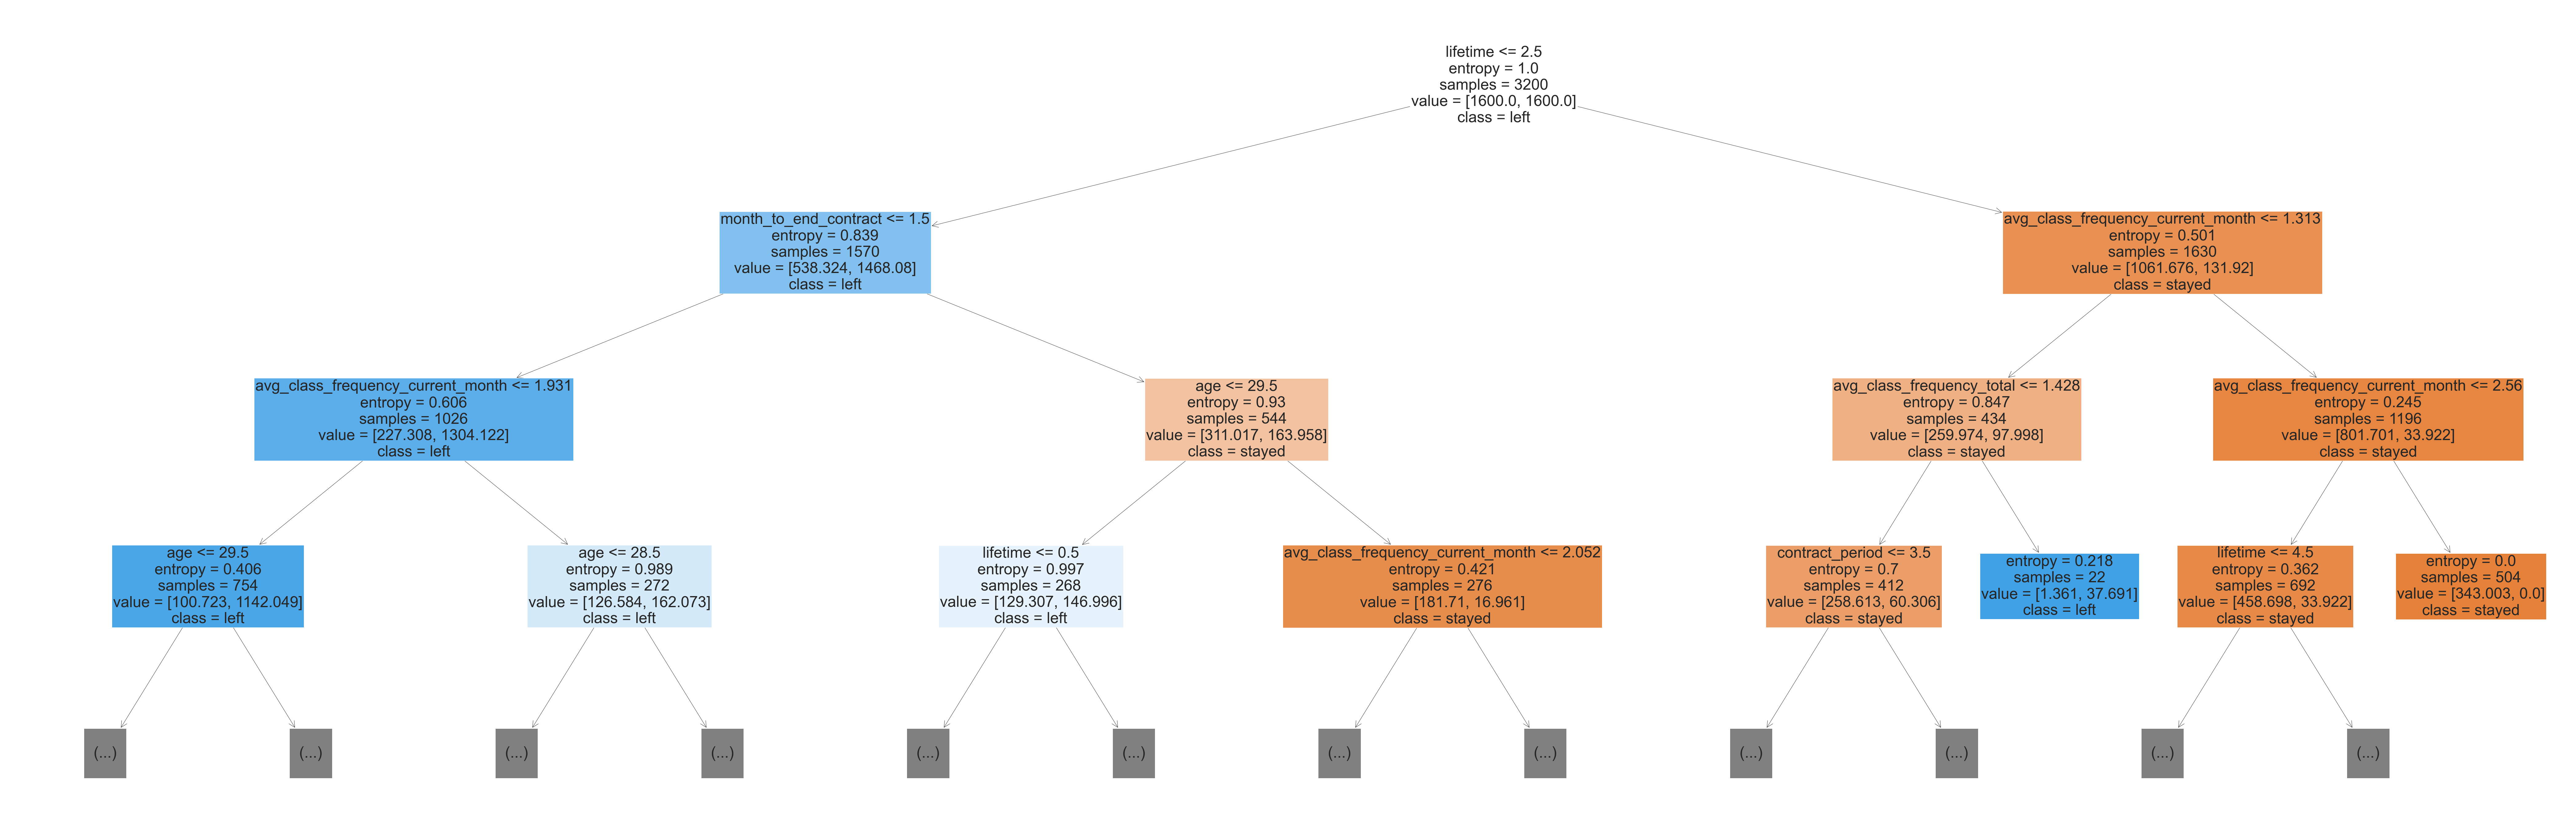

In [27]:
plt.figure(figsize = (150, 50))
plot_tree(
    dt.best_estimator_, filled=True, max_depth=3, 
    fontsize=50, feature_names=X.columns, class_names=['stayed', 'left']
)
plt.show() 

При такой глубине дерева можно пока заметить, что если у клиента время жизни больше 2,5 месяцев и в текущем месяце он в среднем в неделю посещал фитнес-центр: 

* больше 2,6 раза, то он точно останется, и без разницы как часто он занимался раньше

* меньше 1,3 раза в неделю, а раньше обычно больше 1,4 раза в неделю, то он вероятно уйдет


### Случайный лес <a name='rf'></a>

In [28]:
estimator = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

params = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': [10, 25, 50, 100],
    'max_depth': np.arange(5, 11),
    'min_samples_leaf': [5, 10, 20, 50]
}

rf = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring=scoring,
    refit='ROC-AUC',
    cv=5,
    return_train_score=True,
    n_jobs=-1
)

rf.fit(X_train, y_train);

In [29]:
cross_validation_results(rf)

Лучшая модель
criterion: gini
max_depth: 9
min_samples_leaf: 5
n_estimators: 50


,train,validation
mean_accuracy,0.942,0.912
mean_precision,0.846,0.799
mean_recall,0.956,0.892
mean_ROC-AUC,0.987,0.965


In [30]:
test_scores(rf)

Финальная проверка на тесте
Accuracy: 0.909
Precision: 0.788
Recall: 0.896
ROC-AUC: 0.966


На тесте результаты не ухудшились. Посмотрим на оценку важности признаков.

In [31]:
importances = rf.best_estimator_.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances.sort_values(by='importance', ascending=False, key=lambda x: abs(x))

,feature,importance
10,lifetime,0.341046
12,avg_class_frequency_current_month,0.142697
7,age,0.138721
9,month_to_end_contract,0.098832
5,contract_period,0.097818
11,avg_class_frequency_total,0.086397
8,avg_additional_charges_total,0.055449
6,group_visits,0.015310
3,promo_friends,0.007726
2,partner,0.007021


* Случайный лес лучше решающего дерева и хуже логистиеской регрессии

* Самые важные признаки такие же, как у решающего дерева, но их последовательность чуть другая 

### Градиентный бустинг <a name='lgb'></a>

In [32]:
estimator = LGBMClassifier(class_weight='balanced', random_state=24)

params = {
    'n_estimators': [10, 25, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': np.arange(5, 11),
    'min_child_samples': [5, 10, 20, 50]
}

lgb = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring=scoring,
    refit='ROC-AUC',
    cv=5,
    return_train_score=True,
    n_jobs=-1
    
)

lgb.fit(X_train, y_train);

In [33]:
cross_validation_results(lgb)

Лучшая модель
learning_rate: 0.1
max_depth: 9
min_child_samples: 5
n_estimators: 100


,train,validation
mean_accuracy,0.999,0.936
mean_precision,0.996,0.878
mean_recall,1.000,0.883
mean_ROC-AUC,1.000,0.982


In [34]:
test_scores(lgb)

Финальная проверка на тесте
Accuracy: 0.936
Precision: 0.882
Recall: 0.877
ROC-AUC: 0.981


На тесте результаты не ухудшились. Посмотрим на оценку важности признаков.

In [35]:
importances = lgb.best_estimator_.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances.sort_values(by='importance', ascending=False, key=lambda x: abs(x))

,feature,importance
11,avg_class_frequency_total,883
12,avg_class_frequency_current_month,804
8,avg_additional_charges_total,407
7,age,323
10,lifetime,237
5,contract_period,91
6,group_visits,68
9,month_to_end_contract,58
1,near_location,38
3,promo_friends,32


* Градиентный бустинг лучше логистической регрессии по всем метрикам, кроме полноты (и то не сильно)

* Топ признаков все тот же. Любопытно, что время жизни клиента, которые было самым важным у всех предыдущих моделей, у градиентного бустинга на 5 месте по важности

### Вывод <a name='models_conclusion'></a>

* Лучше всего себя показали модели логистической регрессии и градиентного бустинга

* У всех моделей самые важные признаки – время жизни клиента, средняя частота посещений в неделю (в последний месяц и за все время), абонемент, средние дополнительные расходы за все время и возраст

* Бинарные признаки не были особо полезными для моделей предсказания оттока

## Кластеризация клиентов <a name='clustering'></a>

Кластеризуем клиентов с помощью алгоритма агломеративной иерархической клатеризации.

In [36]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

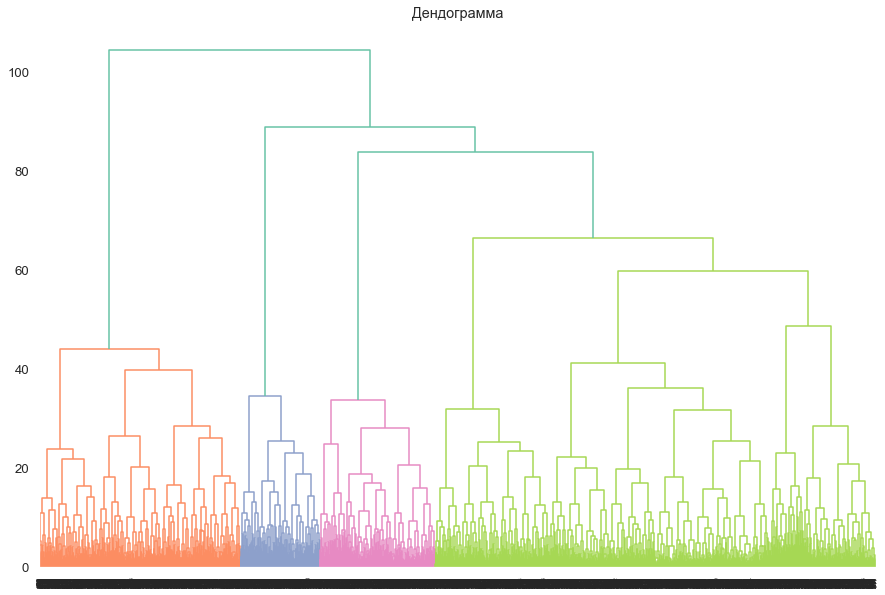

In [37]:
linked = linkage(X_sc, method='ward', metric='euclidean') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендограмма')
plt.show() 

Предлагается разделить выборку клиентов на 4 кластера. Возможно, большее количество класторов было бы более оптимально. Запустим алгоритм агломеративной иерархической кластеризации с числом кластеров от 4 до 6 и выберем лучший по качеству но основе метрики силуэта.

In [38]:
labels = []
silhouettes = []
for i in [4, 5, 6]:
    ac = AgglomerativeClustering(n_clusters=i, linkage='ward', affinity='euclidean')
    labels.append(ac.fit_predict(X_sc))
    silhouettes.append(silhouette_score(X_sc, labels[-1]))

In [39]:
pd.DataFrame({'n_clusters': [4, 5, 6], 'silhouette': silhouettes})

,n_clusters,silhouette
0,4,0.140186
1,5,0.120877
2,6,0.110574


Лучшее качества при разделении выборки клиентов на 4 кластера, такое количество клатеров и выделим.

In [40]:
df['cluster'] = labels[0] + 1

Посмотрим на средние значения бинарных признаков и распределения остальных признаков по кластерам.

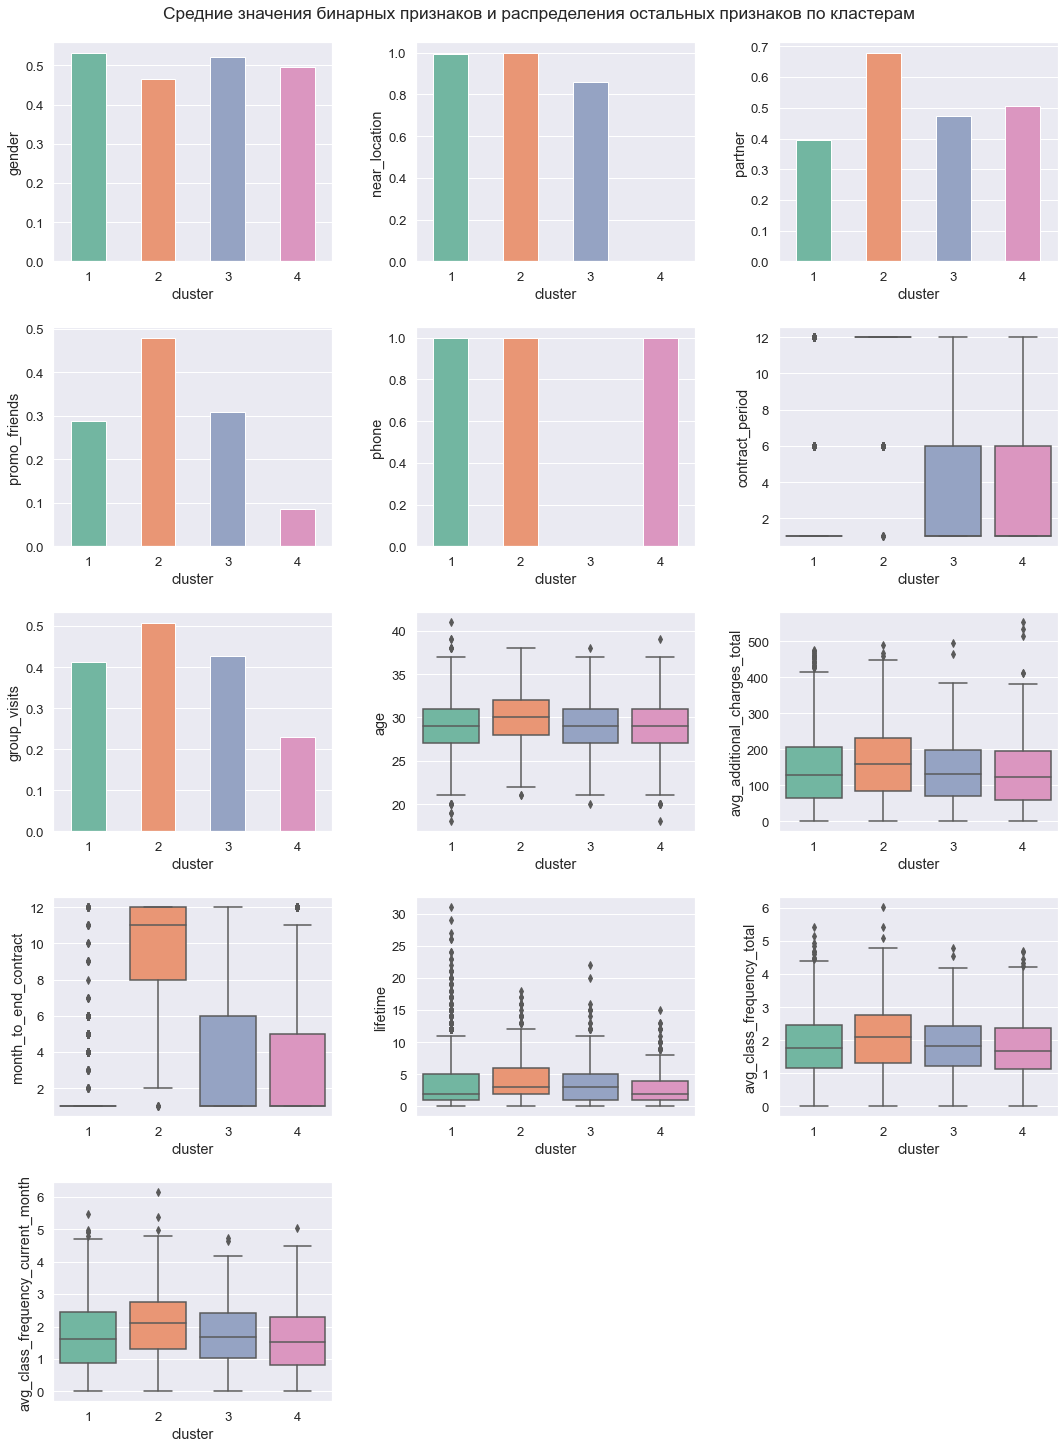

In [41]:
all_features = df.drop(['churn', 'cluster'], axis=1).columns

ncols, nrows = 3, 5
fig = plt.figure(figsize=(18, 25))
for i, col in enumerate(all_features):
    ax = fig.add_subplot(nrows, ncols, i + 1)
    if col in binary_features:
        sns.barplot(data=df, x='cluster', y=col, width=0.5, errorbar=None, ax=ax)
    else:
        sns.boxplot(data=df, y=col, x='cluster', ax=ax)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Средние значения бинарных признаков и распределения остальных признаков по клаcтерам', y=0.9);

In [42]:
cmap = sns.diverging_palette(h_neg=10, h_pos=133, l=60, as_cmap=True)

(
    pd.pivot_table(data=df, columns='cluster', values=df.drop('cluster', axis=1).columns)
    .style.background_gradient(cmap=cmap, axis=1).format(precision=2)
)

cluster,1,2,3,4
age,29.04,29.72,29.28,28.74
avg_additional_charges_total,142.43,164.26,142.59,136.82
avg_class_frequency_current_month,1.69,2.05,1.73,1.61
avg_class_frequency_total,1.83,2.06,1.86,1.78
churn,0.33,0.04,0.27,0.41
contract_period,2.33,10.73,4.64,3.07
gender,0.53,0.46,0.52,0.50
group_visits,0.41,0.51,0.43,0.23
lifetime,3.72,4.29,3.71,2.78
month_to_end_contract,2.17,9.82,4.34,2.90


In [43]:
df.groupby('cluster')['contract_period'].value_counts(normalize=True)

cluster  contract_period
1        1                  0.762470
         6                  0.213302
         12                 0.024228
2        12                 0.792961
         6                  0.201863
         1                  0.005176
3        1                  0.544974
         6                  0.227513
         12                 0.227513
4        1                  0.709619
         6                  0.186933
         12                 0.103448
Name: contract_period, dtype: float64

In [44]:
df['cluster'].value_counts(normalize=True)

1    0.52625
2    0.24150
4    0.13775
3    0.09450
Name: cluster, dtype: float64

### Описание кластеров

**Кластер 1** (53% доли и 33% оттока) – в основном клиенты, у которых абонемент заканчивается через месяц

* Много клиентов, которые недавно впервые обратились в сеть фитнес-центров. Также только в этом кластере есть те редкие клиенты, которые посещают фитнес-центр 2 года и более

* У 76% клиентов абонемент заканчивается через месяц. Всего лишь у 2% клиентов абонемент на 12 месяцев

* Средняя частота посещений в неделю в последнем месяце меньше, чем за все время

* Все клиенты живут или работают рядом с фитнес-центром

* Наименьшая доля клиентов-сотрудников компаний-партнеров среди всех кластеров – 40%

* 29% клиентов пришло по рекомендации друзей

* 41% клиентов, которые посещали групповые занятия в последнем месяце

**Кластер 2** (24% доли и 4% оттока) – лояльные клиенты

* У 20% и 79% клиентов абонемент на 6 и 12 месяцев

* За последний месяц активность клиентов не поменялась

* Все клиенты живут или работают рядом с фитнес-центром

* Средние значения по остальным признакам, кроме пола, больше среди всех кластеров

**Кластер 3** (14% доли и 27% оттока)

Очень похож на первый кластер. 

* 54% клиентов имеет абонемент на 1 месяцев. По остальным приодам абонемента проценты распределены поровну

* Средняя частота посещений в неделю в последнем месяце меньше, чем за все время

* У 86% клиентов дом или работа рядом с фитнес-центром

* Доля клиентов, являющихся сотрудниками компаний-партнеров, составляет 47%

* 30% клиентов пришло по рекомендации друзей

* 43% клиентов ходило на групповые занятия в последнем месяце 

**Кластер 4** (9% доли и 41% оттока) – клиенты, не живущие или работающие рядом с фитнес-центром

* У 71% клиентов через месяц заканчивается абонемент. 10% клиентов приобрели абонемент на 12 месяцев. Период и количество месяцев до окончания абонемента меньше только у кластера 1

* Средняя частота посещений в неделю в последнем месяце меньше, чем за все время

* Ни у одного клиента нет фитнес-центра рядом с домом или работой

* Средние значения по остальным признакам, кроме пола и факта того, что клиент является сотрудником компании-партнера, меньше среди всех кластеров

## Общий вывод и рекомендации <a name='genral_conclusion_and_recommendations'></a>

Главные наблюдения с EDA:
* В основном клиенты живут или работают рядом с фитнес-центром – 85% клиентов

* В сеть фитнес-центров ходят люди молодого и среднего возраста

* Доля посещавших групповые занятия в последнем месяце почти в 2 раза больше среди оставшихся клиентов

* Доля тех, у кого дом или работа рядом с фитнес-центром, немного меньше у решивших уйти клиентов

* Ушедшие клиенты в 2 раза реже приходили по рекомендации друзей

* Доля клиентов-сотрудников компаний-партнеров в 1,5 раза больше у оставшихся клиентов

* Больше чем у половины клиентов оставался 1 месяц абонемента. У таких клиентов самая высокая доля оттока

* Новые клиенты намного чаще уходили, чем оставались. По мере увеличения времени жизни доля оттока снижается. Клиенты, пользующиеся сервисом 6 месяцев и больше, почти не уходили

* В последний месяц ушедшие клиенты стали реже обычного посещать сеть фитнес-центров

* Средняя выручка от дополнительных услуг сети фитнес-центров больше у оставшихся клиентов

* В среднем ушедший клиент моложе оставшегося

<br>

Для прогнозирования вероятности оттока клиента пробовались модели логистической регресси, дерающего дерева, случайного леса и градиентного бустинга. У всех моделей самые важные признаки – время жизни клиента, средняя частота посещений в неделю (в последний месяц и за все время), средние дополнительные расходы за все время, возраст и абонемент. Бинарные признаки не были особо полезными для моделей предсказания оттока. ROC-AUC была ключевой метрикой, по которой выбиралась лучшая модель, также оценивались доля правильных ответов, точность и полнота. В задаче полнота важнее точности, так как лучше находить всех клиентов, которые могут уйти, чем редко ошибаться, говоря что клиент уйдет. Лучше всего себя показали логистическая регрессия и градиентный бустинг. Логистическая регрессия уступает градиентному бустингу во всех метриках, кроме полноты.

<br>

С помощью агломеративной иерархической кластеризации было выделено 4 кластера:

1. В основном клиенты, у которых абонемент заканчивается через месяц (53% доли и 33% оттока) 

2. Лояльные клиенты (24% доли и 4% оттока). Только в этом кластере средняя частота посещений в неделю за последний месяц не поменялась, у остальных кластеров она стала хуже обычного. Средние значения по всем признакам, кроме пола, больше, чем у других кластеров

3. Очень похож на 1 кластер, но имеет чуть меньше клиентов с истекающим абонементом в следующем месяце и больше средние значения почти всех признаков (14% доли и 27% оттока)

4. Клиенты, не живущие или работающие рядом с фитнес-центром (9% доли и 41% оттока). Расстояние скорее всего и повлияло на то, что у этого кластера средние значения почти всех признаков наименьшие 

<br>

Рекомендации по работе с клиентами:
* Отправлять смс с напоминанием о тренировке тем, кто начал ходить в фитнес-центр реже, чем обычно 

* Предложить скидки на групповые занятия клиентам из кластера 1 и 3

* Привлекать клиентов, которые живут или работают с сетью фитнес-центров

* За друга, пришедшего по рекомендации, давать скидку на дополнительные услуги или групповые занятия

* Клиентам, которые имеют абонемент на месяц и с высокой вероятностью могут уйти, предлагать скидки на продление абонемента (на 6 и 12 месяцев сделать скидку больше)